# Spatial interpolation of point data using Inverse Distance Weighting (IDW)
##### Author: Kathryn Berger, August 2020

### Description

We are interested in performing a basic spatial analysis on our soil pH data points within our area of interest, the Rothamsted Research campus. In this example, we will use the Inverse Distance Weighting (IDW) method to convert our data points into a continuous raster layer.

### Importing requirements

In [ ]:

options("Ncpus" = parallel::detectCores())

packages <- c("gstat", "httr", "jsonlite", "lubridate", "raster", "rgdal", "sp","tidyverse")
if (length(setdiff(packages, rownames(installed.packages()))) > 0) {
  install.packages(setdiff(packages, rownames(installed.packages())), Ncpus=getOption("Ncpus", 1L), INSTALL_opts = '--no-lock', clean = TRUE)  
}

library(gstat)
library(httr)
library(jsonlite)
library(lubridate)
library(raster)
library(rgdal)     
library(sp)
library(tidyverse)

### Accessing the data from your geospatial GraphQL query

First, we will require a successful GraphQL query __[here](https://app.agrimetrics.co.uk/graph-explorer
)__ that includes the following: 
* A bounding box for the area of interest to be used as our ***geoFilter***
* For our geospatial query to work, we must have selected ***location*** options in our GraphQL query
* In this case, we have selected to retrieve the ***centroid*** values for each of the geospatialMeasure grid values as observed in the payload shown below
* An ***api-key*** of our own
* Depending on your subscription (trial vs. paid) amount of data available in this demo may vary. 

In [2]:
options(stringsAsFactors = FALSE)

url = "https://api.agrimetrics.co.uk/graphql"
API_KEY <- Sys.getenv("API_KEY", "API_KEY")

# our query searches for soilPH and invertebrate count for area within defined polygon geospatial filter
# below we copy the payload from our GraphQL query using the Rothamsted bounding box for our geoFilter
# note the use added quotations used around the copied GraphQL query for reading into R
 
payload = '{"query":"query getFieldIdsNearLocation { geospatialMeasures(geoFilter: {location: {type: Polygon, coordinates: [[[-0.401073,51.80076],[-0.356222,51.80076],[-0.356222,51.819771],[-0.401073,51.819771],[-0.401073,51.80076]]]}}) { soilPH { unit value location { centroid } } soilTotalAbundanceOfInvertebrates { unit value location { centroid } } } } "}'

# you will need a subscription key first
# replace "api-key" with your own
r<-POST(url, body = payload, add_headers(.headers = c('Accept'="application/json",'Ocp-Apim-Subscription-Key'= API_KEY,'Content-Type'="application/json",'Accept-Encoding'="gzip, deflate, br")))

# reviewing the contents of the above query 
# if it has worked correctly you should see our two requested geospatialMeasures (soil PH and invertebrate abundance) below
str(httr::content(r, as = "parsed", type = "application/json"), max.level = 3)


List of 1
 $ data:List of 1
  ..$ geospatialMeasures:List of 2
  .. ..$ soilPH                           :List of 8
  .. ..$ soilTotalAbundanceOfInvertebrates:List of 8


### Converting our query output into a data frame 

In [3]:
# output of request into flattened json
get_data_text <- content(r, "text")
get_data_json <- jsonlite::fromJSON(get_data_text, flatten = TRUE)

# converting json to data frame
get_data_df <- as.data.frame(get_data_json)

# to examine a sample of our data frame  
head(get_data_df)


,data.geospatialMeasures.soilPH.unit,data.geospatialMeasures.soilPH.value,data.geospatialMeasures.soilPH.location.centroid.type,data.geospatialMeasures.soilPH.location.centroid.coordinates,data.geospatialMeasures.soilTotalAbundanceOfInvertebrates.unit,data.geospatialMeasures.soilTotalAbundanceOfInvertebrates.value,data.geospatialMeasures.soilTotalAbundanceOfInvertebrates.location.centroid.type,data.geospatialMeasures.soilTotalAbundanceOfInvertebrates.location.centroid.coordinates
,<chr>,<dbl>,<chr>,<list>,<chr>,<dbl>,<chr>,<list>
1,http://data.agrimetrics.co.uk/units/ph,6.068252,Point,"-0.3986048, 51.8092248",http://data.agrimetrics.co.uk/units/count,56.20854,Point,"-0.3986048, 51.8092248"
2,http://data.agrimetrics.co.uk/units/ph,7.046670,Point,"-0.3844273, 51.8000391",http://data.agrimetrics.co.uk/units/count,30.71813,Point,"-0.3844273, 51.8000391"
3,http://data.agrimetrics.co.uk/units/ph,7.046670,Point,"-0.384106, 51.809026",http://data.agrimetrics.co.uk/units/count,30.71813,Point,"-0.384106, 51.809026"
4,http://data.agrimetrics.co.uk/units/ph,7.231666,Point,"-0.3699316, 51.7998390",http://data.agrimetrics.co.uk/units/count,48.82695,Point,"-0.3699316, 51.7998390"
5,http://data.agrimetrics.co.uk/units/ph,8.210084,Point,"-0.3696074, 51.8088264",http://data.agrimetrics.co.uk/units/count,23.33654,Point,"-0.3696074, 51.8088264"
6,http://data.agrimetrics.co.uk/units/ph,6.044802,Point,"-0.355109, 51.808624",http://data.agrimetrics.co.uk/units/count,36.80287,Point,"-0.355109, 51.808624"


### Converting our geospatialMeasure (soil pH) into a spatial points data frame

Our data frame consists of two geospatialMeasures (soil pH and soil invertebrate abundance), each of which may have their own different spatial resolutions (and corresponding coordinates). Therefore, we must treat each geospatialMeasure separately. This means we will deal with each data frame one at a time.  

In this example, we will focus on the soil pH data set only. Here we convert the data set into a ***SpatialPointsDataFrames***. We will use this output to produce our interpolated data layer.  

In [4]:
# we must extract the soil PH data from our dataframe, to do so we need to know which columns correspond 
# Using the section above to examine our headers, we subset the first four columns to focus on soil PH
soilph_data <-get_data_df[, 1:4]

# r has a problem with unseparated coordinates, so we fix it here, by separating them 
soilph_data <- soilph_data %>%
  mutate(point_lat = unlist(map(soilph_data$data.geospatialMeasures.soilPH.location.centroid.coordinates,2)),
         point_long = unlist(map(soilph_data$data.geospatialMeasures.soilPH.location.centroid.coordinates,1)))

# dropping coordinates column as it will cause confusion downstream
soilph_data$data.geospatialMeasures.soilPH.location.centroid.coordinates <- NULL

# we assign an EPSG string for coordinates system latitude and longitude
latlong = "+init=epsg:4326"


# making a SpatialPointsDataFrame (spdf) object
soilph_spdf <- sp::SpatialPointsDataFrame(coords=soilph_data[, c("point_long", "point_lat")],
                                      data = soilph_data, 
                                      proj4string=CRS(as.character(latlong)))

# To produce a .shp file that can be used across a number of GIS platforms we convert the spdf object to a .shp file
# but ESRI shapefiles limit headers to 10 characters, so we must rename them here using our knowledge of the column headers
# using spdf 'data' slot we rename the column headers where required
colnames(soilph_spdf@data)[2] = "value"
colnames(soilph_spdf@data)[1] = "unit"
colnames(soilph_spdf@data)[3] = "type"

### Plotting our soil pH spatial points data frame

By plotting our soil pH data points, we are able to understand the distribution of the data we have available. Using the **extent function**, we can determine the bounding box for our interpolated raster layer. 

class      : Extent 
xmin       : -0.3986048 
xmax       : -0.355109 
ymin       : 51.79984 
ymax       : 51.81821 

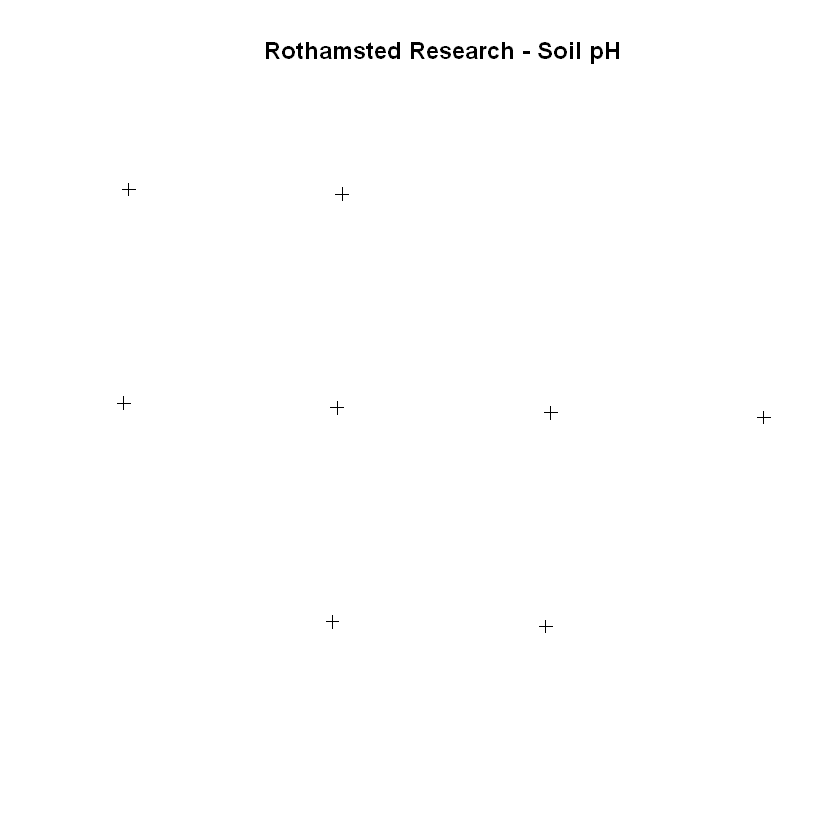

In [5]:
plot(soilph_spdf,
     main = "Rothamsted Research - Soil pH")

extent(soilph_spdf)

### Spatial Interpolation

In the step below, we will set up an **empty grid** using the bounding box we identified above to develop a reasonable area to perform our interpolation. 

Next, We will then plot our soil pH values over the empty grid. 

And finally, we will use the **Inverse Distance Weighting (IDW) method** to populate the empty grid with our new interpolated values. This final step will produce our soil pH raster layer.


In [6]:
# creating an empty grid upon which to perform 
# Inverse Distance Interpolation (IDW)
# using a logical bounding box for area

x_range <- as.numeric(c(-0.40, -0.35 ))  # min/max longitude of the interpolation area
y_range <- as.numeric(c(51.79, 51.82))  # min/max latitude of the interpolation area

# create an empty grid of values ranging from the xmin-xmax, ymin-ymax
# we use a 0.01 degree spatial resolution to build a grid that is approximately 1 km
grd <- expand.grid(x = seq(from = x_range[1],
                   to = x_range[2], 
                   by = 0.01),
                   y = seq(from = y_range[1], to = y_range[2], 
                       by = 0.01))  # expand points to grid


In [7]:
# examining our spatial points data frame
head(soilph_spdf)
str(soilph_spdf)


,unit,value,type,point_lat,point_long
,<chr>,<dbl>,<chr>,<dbl>,<dbl>
1,http://data.agrimetrics.co.uk/units/ph,6.068252,Point,51.80922,-0.3986048
2,http://data.agrimetrics.co.uk/units/ph,7.046670,Point,51.80004,-0.3844273
3,http://data.agrimetrics.co.uk/units/ph,7.046670,Point,51.80903,-0.3841060
4,http://data.agrimetrics.co.uk/units/ph,7.231666,Point,51.79984,-0.3699316
5,http://data.agrimetrics.co.uk/units/ph,8.210084,Point,51.80883,-0.3696074
6,http://data.agrimetrics.co.uk/units/ph,6.044802,Point,51.80862,-0.3551090


Formal class 'SpatialPointsDataFrame' [package "sp"] with 5 slots
  ..@ data       :'data.frame':	8 obs. of  5 variables:
  .. ..$ unit      : chr [1:8] "http://data.agrimetrics.co.uk/units/ph" "http://data.agrimetrics.co.uk/units/ph" "http://data.agrimetrics.co.uk/units/ph" "http://data.agrimetrics.co.uk/units/ph" ...
  .. ..$ value     : num [1:8] 6.07 7.05 7.05 7.23 8.21 ...
  .. ..$ type      : chr [1:8] "Point" "Point" "Point" "Point" ...
  .. ..$ point_lat : num [1:8] 51.8 51.8 51.8 51.8 51.8 ...
  .. ..$ point_long: num [1:8] -0.399 -0.384 -0.384 -0.37 -0.37 ...
  ..@ coords.nrs : num(0) 
  ..@ coords     : num [1:8, 1:2] -0.399 -0.384 -0.384 -0.37 -0.37 ...
  .. ..- attr(*, "dimnames")=List of 2
  .. .. ..$ : NULL
  .. .. ..$ : chr [1:2] "point_long" "point_lat"
  ..@ bbox       : num [1:2, 1:2] -0.399 51.8 -0.355 51.818
  .. ..- attr(*, "dimnames")=List of 2
  .. .. ..$ : chr [1:2] "point_long" "point_lat"
  .. .. ..$ : chr [1:2] "min" "max"
  ..@ proj4string:Formal class 'CRS

In [8]:
# Convert grd object to a matrix and then turn into a spatial points object
coordinates(grd) <- ~x + y
# turn into a spatial pixels object
gridded(grd) <- TRUE

# checking projection of our grid
str(grd)

Formal class 'SpatialPixels' [package "sp"] with 5 slots
  ..@ grid       :Formal class 'GridTopology' [package "sp"] with 3 slots
  .. .. ..@ cellcentre.offset: Named num [1:2] -0.4 51.8
  .. .. .. ..- attr(*, "names")= chr [1:2] "x" "y"
  .. .. ..@ cellsize         : Named num [1:2] 0.01 0.01
  .. .. .. ..- attr(*, "names")= chr [1:2] "x" "y"
  .. .. ..@ cells.dim        : Named int [1:2] 6 4
  .. .. .. ..- attr(*, "names")= chr [1:2] "x" "y"
  ..@ grid.index : int [1:24] 19 20 21 22 23 24 13 14 15 16 ...
  ..@ coords     : num [1:24, 1:2] -0.4 -0.39 -0.38 -0.37 -0.36 -0.35 -0.4 -0.39 -0.38 -0.37 ...
  .. ..- attr(*, "dimnames")=List of 2
  .. .. ..$ : chr [1:24] "1" "2" "3" "4" ...
  .. .. ..$ : chr [1:2] "x" "y"
  ..@ bbox       : num [1:2, 1:2] -0.405 51.785 -0.345 51.825
  .. ..- attr(*, "dimnames")=List of 2
  .. .. ..$ : chr [1:2] "x" "y"
  .. .. ..$ : chr [1:2] "min" "max"
  ..@ proj4string:Formal class 'CRS' [package "sp"] with 1 slot
  .. .. ..@ projargs: chr NA


In [9]:
# assiging a formal coordinate reference system (CRS) as we were missing it in step above
# this is important, as it needs to match the CRS assigned to the data point values we will use for interpolation 
# in this example we use the same CRS definition as was identified within the soilph_spdf

proj4string(grd) <- CRS("+proj=longlat +datum=WGS84 +no_defs")

# verifying the CRS definition is now the same as used in soilph_spdf
str(grd)


Formal class 'SpatialPixels' [package "sp"] with 5 slots
  ..@ grid       :Formal class 'GridTopology' [package "sp"] with 3 slots
  .. .. ..@ cellcentre.offset: Named num [1:2] -0.4 51.8
  .. .. .. ..- attr(*, "names")= chr [1:2] "x" "y"
  .. .. ..@ cellsize         : Named num [1:2] 0.01 0.01
  .. .. .. ..- attr(*, "names")= chr [1:2] "x" "y"
  .. .. ..@ cells.dim        : Named int [1:2] 6 4
  .. .. .. ..- attr(*, "names")= chr [1:2] "x" "y"
  ..@ grid.index : int [1:24] 19 20 21 22 23 24 13 14 15 16 ...
  ..@ coords     : num [1:24, 1:2] -0.4 -0.39 -0.38 -0.37 -0.36 -0.35 -0.4 -0.39 -0.38 -0.37 ...
  .. ..- attr(*, "dimnames")=List of 2
  .. .. ..$ : chr [1:24] "1" "2" "3" "4" ...
  .. .. ..$ : chr [1:2] "x" "y"
  ..@ bbox       : num [1:2, 1:2] -0.405 51.785 -0.345 51.825
  .. ..- attr(*, "dimnames")=List of 2
  .. .. ..$ : chr [1:2] "x" "y"
  .. .. ..$ : chr [1:2] "min" "max"
  ..@ proj4string:Formal class 'CRS' [package "sp"] with 1 slot
  .. .. ..@ projargs: chr "+proj=longlat 

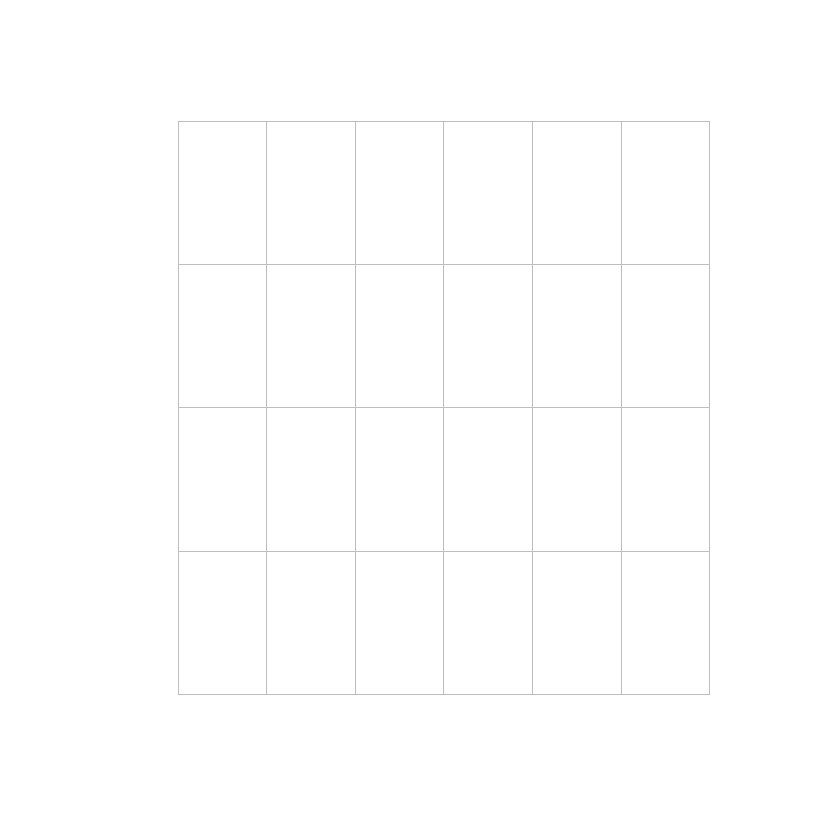

In [10]:
# view our empty grid 
plot(grd, cex = 1.5, col = "grey")

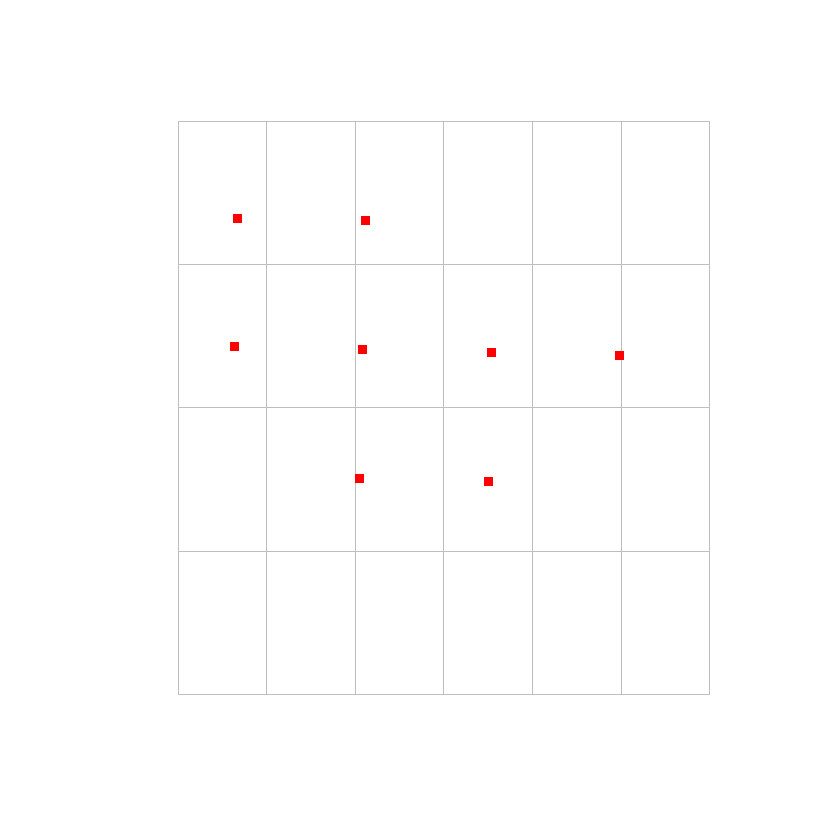

In [11]:
# view our empty grid with our data points added
plot(grd, cex = 1.5, col = "grey")
plot(soilph_spdf,
       pch = 15,
       col = "red",
       cex = 1,
       add = TRUE)

Below, we perform the IDW interpolation of our soil pH data points to the empty grid. Using the idw() function, 
we tell the formula "soilph_spdf ~ 1" to use the latitude and longitude coordinates and soil pH values from our spatial points data frame to perform our interpolated data layer. 

The **location** argument are the spatial points that you want to interpolate onto the grid. 
The **newdata** argument is the empty grid onto which we will insert out soil pH values. 
The **idp** argument is the power value used for interpolation and it controls the significance of the surrounding points on the interpolated value. Power values generally range from 0.5 to 3. The higher the power, the lesser the influence from more distance points, and the truer the surface will be to the actual data points. The lower the value, the smoother the interpolated surface will be.

In [12]:
# interpolate the our soil pH data at the Rothamsted Research site, using a power of 1
idw_power1 <- gstat::idw(formula = value ~ 1,
           locations = soilph_spdf,
           newdata = grd,
           idp = 1)

## verifying the class of our interpolated data
# notice that the output data is now a SpatialPixelsDataFrame
class(idw_power1)


Warning message in proj4string(d$data):
"CRS object has comment, which is lost in output"
Warning message in proj4string(newdata):
"CRS object has comment, which is lost in output"


[inverse distance weighted interpolation]


Warning message in proj4string(newdata):
"CRS object has comment, which is lost in output"


[1] "SpatialPixelsDataFrame"
attr(,"package")
[1] "sp"

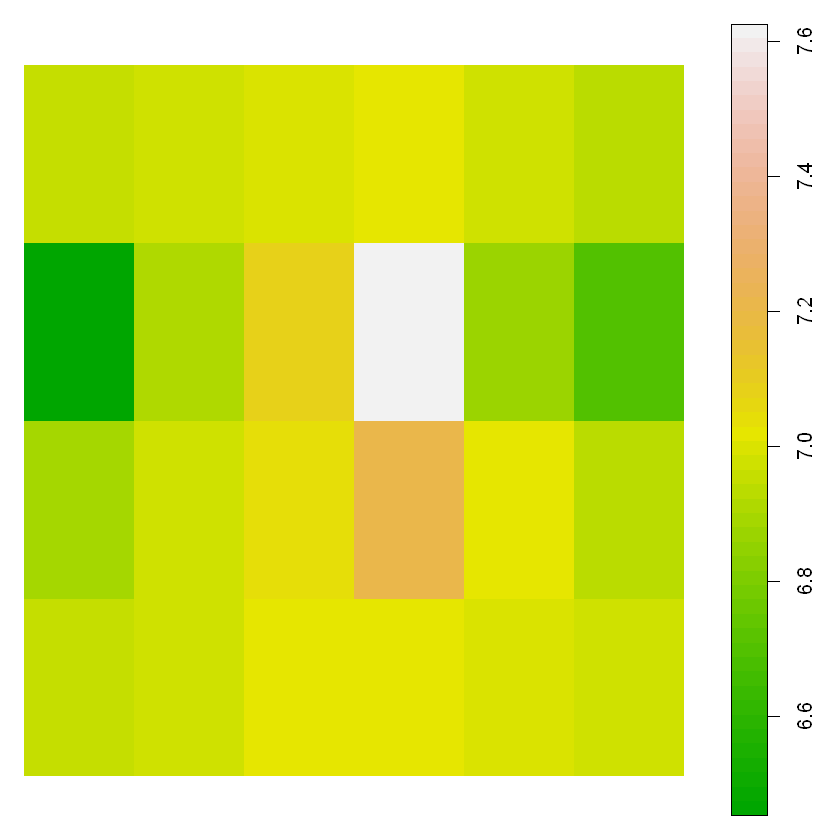

In [13]:
# plotting the data, we get an
plot(idw_power1,
     col = terrain.colors(55))

### Conclusion
 
In this example, we have successfully performed a simple spatial interpolation on the soil pH data points derived from our GraphQL query. To do this, we converted our point data to raster format using the IDW method for spatial interpolation. 